# Tipos de guitarras?

## Informações do Autor

Erick Melo Vidal de Oliveira - 190027355

## Objetivo

O modelo a seguir tem como objetivo identificar qual é o modelo de uma determinada guitarra

## 1. Baixando imagens de cada tipo de guitarra

Para iniciar o processo, é necessária a intalação e importação de alguns pacotes e bibliotecas que serão utilizadas durante o projeto, sendo a FastAI e a DuckDuckGo as principais.

In [2]:
# Primeiramente deve ser feita a instalação do fastai para a criação e modelagem do problema
# e do duckduckgo_search para pesquisar o url das imagens desejadas.
!pip install -Uqq fastai duckduckgo_search

# Em seguida, importar os pacotes que serão utilizados.
import os
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

Com os recursos importados, agora é possível criar a função que irá fazer a busca das imagens e armazená-las em uma pasta de cada um dos 6 tipos de guitarra que serão utilizados neste artigo, sendo eles:
* Telecaster;
* Les Paul;
* Stratocaster;
* SG;
* Flying V;
* Explorer;

In [3]:
# Essa função irá receber um term que será pesquisado e um número máximo de imagens para 
# ser pesquisado, pré-definido como 100.
def pesquisar_imagem(term, max_images=100):
    print(f"Pesquisando por '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Na lição 2 do curso do fastai, utilizada como base para este artigo, foi utilizada a função Bing para realizar a busca das imagens, mas optei por continuar utilizando a DuckDuckGo por ser mais simples e obter praticamente os mesmos resultados.

In [4]:
# Moedlos de guitarra
searches = 'Telecaster', 'Les Paul', 'Stratocaster', 'SG', 'Flying V', 'Explorer'
path = Path('guitars')

# Loop que irá pesquisar imagens de cada tipo de guitarra
for guitar in searches:
    dest = (path/guitar)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=pesquisar_imagem(f'{guitar} guitar'))
    resize_images(path/guitar, max_size=400, dest=path/guitar)

Pesquisando por 'Telecaster guitar'
Pesquisando por 'Les Paul guitar'
Pesquisando por 'Stratocaster guitar'
Pesquisando por 'SG guitar'
Pesquisando por 'Flying V guitar'
Pesquisando por 'Explorer guitar'


## 2. Treinando o modelo

Com as imagens já baixadas, agora é possível utilizá-las para treinar o modelo. Porém, ainda existe a possibilidade de algumas imagens baixadas estarem com erro. Portanto, é necessário excluir essas imagens para o modelo não utilizá-las como parâmetro para aprender.

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

Após excluir as imagens defeituosas, será criado o DataLoader, que é um objeto que contém um modelo de treino (as imagens baixadas) e uma validação de imagens para checar a acurácia do modelo. Com o FastAI é possível fazer isso de maneira bem simples e exibir algumas imagens encontradas utilizando o DataBlock, que utiliza alguns parâmetros para melhorar o treino, sendo eles:
* `blocks=(ImageBlock, CategoryBlock),` define o Input (imagem baixada) e o Output (categoria de cada imagem) do bloco.
* `get_items=get_image_files,` retorna a lista de todas as imagens baixadas
* `splitter=RandomSplitter(valid_pct=0.2, seed=42),` divide os dados entre treinamente e validação aleatoriamente, utilizando 20% dos dados para o conjunto de validação
* `get_y=parent_label,` recupera a cadegoria de cada imagem baixada, nesse caso, o nome de cada filo
* `item_tfms=[RandomResizedCrop(224, min_scale=0.5)]` define o tamanho da imagem para 192x192 pixels


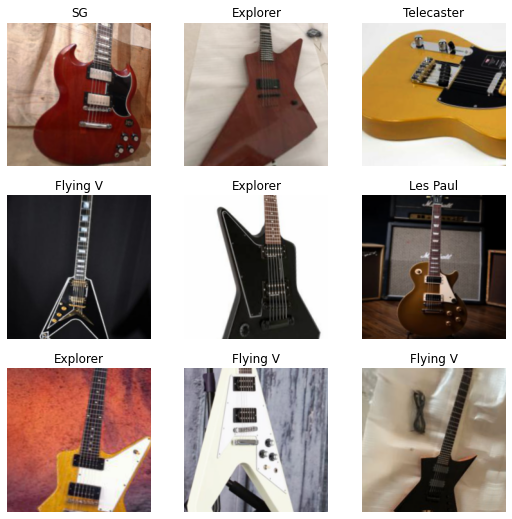

In [7]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[RandomResizedCrop(224, min_scale=0.5)],
    batch_tfms=aug_transforms())
dls = data.dataloaders(path)
dls.show_batch(max_n=9)

Agora os parâmetros definidos podem ser utilizados para treinar o modelo, e para isso, será utilizado o modelo resnet18, que consiste em uma rede neural com capacidade de aprender representações para uma ampla variedade de imagens.

Para auxiliar esse aprendizado, será utilizado o método `fine_tune()` da FastAI, que utiliza as melhores práticas para melhorar um modelo pré-treinado, nesse caso o resnet18.

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.606591,1.506864,0.525862,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.334030,0.945234,0.318966,00:05
1,1.203445,0.693393,0.284483,00:04
2,0.992083,0.575534,0.181034,00:04
3,0.829356,0.503586,0.189655,00:05
4,0.688767,0.477393,0.155172,00:04
5,0.606225,0.463355,0.155172,00:04
6,0.547160,0.454823,0.146552,00:05


Foram utilizadas 7 épocas no fine_tune() porque a partir da sétima época, o error_rate continua o mesmo, então não seria necessário mais do que isso.

Para melhorar a visualização dos erros do modelo, o FastAI possui a função `plot_confusion_matrix()`, que exibe uma matriz de confusão mostrando a divisão das classes utilizadas e em qual classificação o modelo está errando, sendo que a diagonal principal possui as predições corretas que o modelo fez.

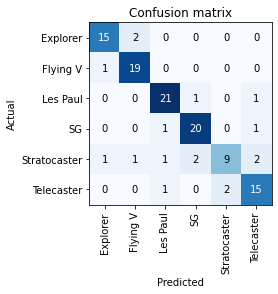

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Com a matriz gerada, é possível perceber que as principais classes onde ocorrem os erros de predição são na Stratocaster, LesPaul e Telecaster, o que me surpreendeu um pouco em relação ao modelo Stratocaster, pois ele é mais fácil de se diferenciar dos demais. Já os tipos Telecaster e LesPaul são realmente semelhantes, e por isso eu já esperava que o modelo se confundisse nessas classificações.

Além da matriz de confusão, também é importante entender porque os erros ocorreram, e para isso temos a função `plot_top_losses()` que mostra a predição que o modelo fez, o que deveria ser, a perda e a probabilidade de certeza da predição, além de mostrar a imagem utilizada, facilitando a identificação se o erro foi na predição do modelo ou na imagem coletada.

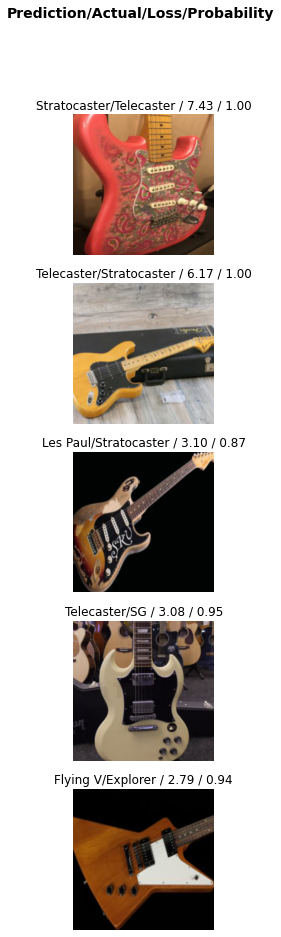

In [17]:
interp.plot_top_losses(5, ncols=1)

Com esses resultados, é possível percerber que houve tanto erros de predição (como na imagem 2, que é uma guitarra Stratocaster mas o modelo classificou como Telecaster) como erros na imagem coletada (como na imagem 1, que realmente é uma guitarra Stratocaster e o modelo acertou a predição, mas a imagem foi baixada como se fosse uma guitarra Telecaster). Por isso então, é possível deletar ou reclassificar erros como esses exemplificados, utilizando a função `ImageClassifierCleaner()`.

In [19]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

Com essa função, é possível visualizar tanto as imagens que foram utilizadas para o treino do modelo quanto as que foram utilizadas para validação, e em cada uma delas é possível fazer as alterações necessárias. No meu modelo, eu precisei alterar várias guitarras que estavam erradas nas categorias de Stratocaster e Telecaster.

Após identificar as imagens erradas e reclassificá-las ou deletá-las, foi utilizado o trecho de código abaixo para realmente executar a ação que eu havia escolhido, sendo o trecho `for idx in cleaner.delete(): cleaner.fns[idx].unlink() ` utilizado para as imagens marcadas para serem deletadas e o trecho `for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)` utilizado para reclassificar as imagens.

In [23]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Com as imagens já corrigidas, agora é possível treinar o modelo novamente para reduzir o número de erros cometidos. É possível notar que o error_rate do modelo já diminuiu, o que significa que agora ele possui uma precisão maior nas predições.

In [28]:
dls = data.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,2.895241,1.171953,0.469565,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.335685,0.860801,0.321739,00:04
1,1.122561,0.574104,0.252174,00:05
2,0.929797,0.342669,0.147826,00:04
3,0.760937,0.286672,0.113043,00:04
4,0.635278,0.297571,0.104348,00:04
5,0.552189,0.285626,0.121739,00:04
6,0.484271,0.283816,0.113043,00:04


## 3. Utilizando o modelo

A seguir, foi realizada uma pesquisa para cada um dos modelos de guitarra citados anteriormente.

Pesquisando por 'Telecaster guitar'


Isso é uma: Telecaster.
A probabilidade de ser uma Telecaster é: 0.9980


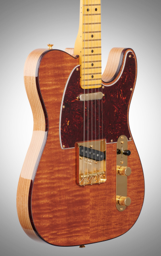

In [29]:
urls = pesquisar_imagem('Telecaster guitar', max_images=1)
image = 'guitar.jpg'
download_url(urls[0], image, show_progress=False)

guitar,_,probs = learn.predict(PILImage.create('guitar.jpg'))
print(f"Isso é uma: {guitar}.")
print(f"A probabilidade de ser uma {guitar} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Les Paul guitar'


Isso é uma: Les Paul.
A probabilidade de ser uma Les Paul é: 0.9715


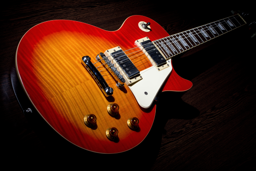

In [30]:
urls = pesquisar_imagem('Les Paul guitar', max_images=1)
image = 'guitar.jpg'
download_url(urls[0], image, show_progress=False)

guitar,_,probs = learn.predict(PILImage.create('guitar.jpg'))
print(f"Isso é uma: {guitar}.")
print(f"A probabilidade de ser uma {guitar} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Stratocaster guitar'


Isso é uma: Stratocaster.
A probabilidade de ser uma Stratocaster é: 0.9837


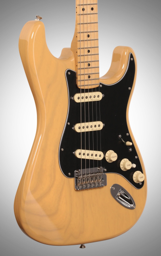

In [31]:
urls = pesquisar_imagem('Stratocaster guitar', max_images=1)
image = 'guitar.jpg'
download_url(urls[0], image, show_progress=False)

guitar,_,probs = learn.predict(PILImage.create('guitar.jpg'))
print(f"Isso é uma: {guitar}.")
print(f"A probabilidade de ser uma {guitar} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'SG guitar'


Isso é uma: SG.
A probabilidade de ser uma SG é: 0.9999


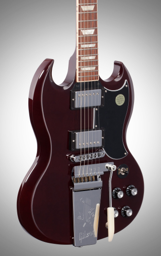

In [32]:
urls = pesquisar_imagem('SG guitar', max_images=1)
image = 'guitar.jpg'
download_url(urls[0], image, show_progress=False)

guitar,_,probs = learn.predict(PILImage.create('guitar.jpg'))
print(f"Isso é uma: {guitar}.")
print(f"A probabilidade de ser uma {guitar} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Flying V guitar'


Isso é uma: Flying V.
A probabilidade de ser uma Flying V é: 1.0000


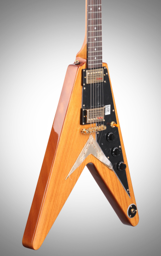

In [33]:
urls = pesquisar_imagem('Flying V guitar', max_images=1)
image = 'guitar.jpg'
download_url(urls[0], image, show_progress=False)

guitar,_,probs = learn.predict(PILImage.create('guitar.jpg'))
print(f"Isso é uma: {guitar}.")
print(f"A probabilidade de ser uma {guitar} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

Pesquisando por 'Explorer guitar'


Isso é uma: Explorer.
A probabilidade de ser uma Explorer é: 0.9998


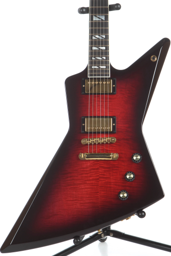

In [34]:
urls = pesquisar_imagem('Explorer guitar', max_images=1)
image = 'guitar.jpg'
download_url(urls[0], image, show_progress=False)

guitar,_,probs = learn.predict(PILImage.create('guitar.jpg'))
print(f"Isso é uma: {guitar}.")
print(f"A probabilidade de ser uma {guitar} é: {probs[_]:.4f}")

Image.open(image).to_thumb(256,256)

## 4. Deploy do Modelo

Para realizar o deploy deste modelo, primeiro foi necessário exprtá-lo, utilizando a função `export()` para isso, o que gerou um arquivo .pkl que pode ser baixado.

In [32]:
learn.export('guitars.pkl')

Em seguida, foi utilizada a plataforma do Hugging Face para rodar a aplicação. Para isso foi criada uma conta e um repositório na plataforma e depois realizado o clone para a minha máquina local. A partir disso já era possível adicionar na pasta do repositório, o arquivo .pkl gerado anteriormente, além disso, também foi adicionado um arquivo app.py (conforme o tutorial disponível [aqui](https://tmabraham.github.io/blog/gradio_hf_spaces_tutorial)) contendo o código abaixo e uma pasta de imagens que serviriam de exemplo para testar o modelo.

In [ ]:
import gradio as gr
from fastai.vision.all import *
import skimage 

learn = load_learner('guitars.pkl')

labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "Guitar Classifier"
examples = ['assets/Telecaster.jpg', 'assets/Les_Paul.jpg', 'assets/Stratocaster.jpg', 'assets/SG.jpg', 'assets/Flying_V.jpg', 'assets/Explorer.jpg']
interpretation='default'
enable_queue=True

gr.Interface(fn=predict,inputs=gr.inputs.Image(shape=(512, 512)),outputs=gr.outputs.Label(num_top_classes=5),title=title,examples=examples,interpretation=interpretation,enable_queue=enable_queue).launch()

Após a adição dos arquivos, foi realizado um push para o repositório. Porém, eu me deparei com um erro no site que dizia que não estava encontrando o "fastai" para ser importado e por isso, a minha aplicação não estava funcionando. Para resolver isso, eu descobri que bastava adicionar um arquivo `requirements.txt` contendo apenas as seguintes linhas:

`fastai
scikit-image`


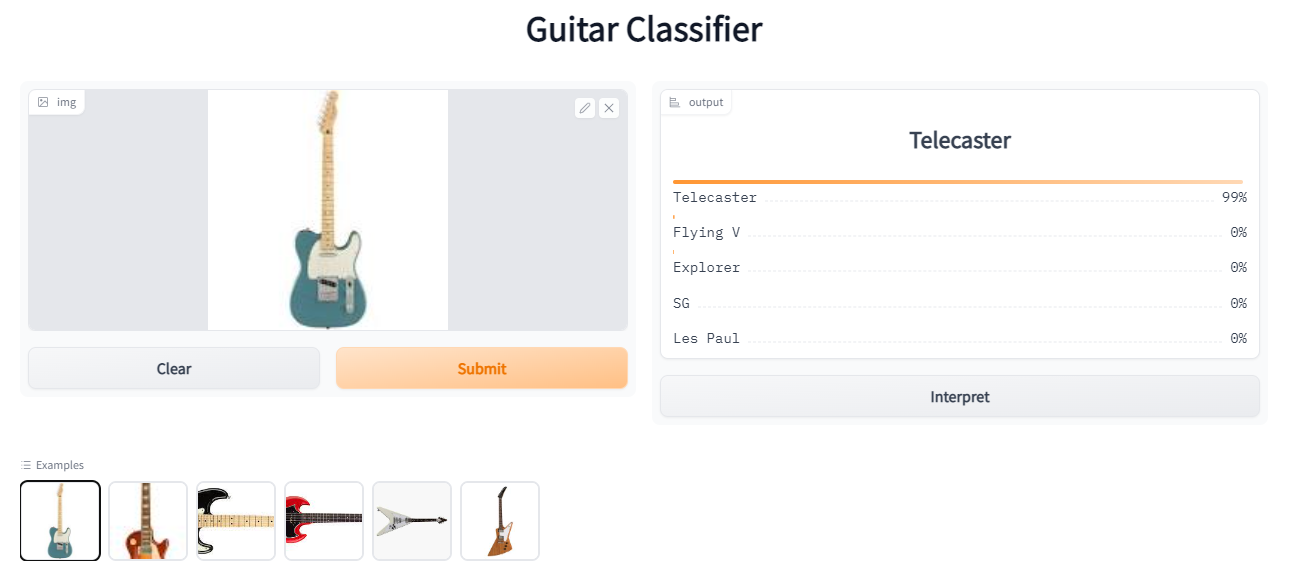

O modelo agora está funcionando e está disponível em: https://huggingface.co/spaces/ErickMVdO/guitars